<a href="https://colab.research.google.com/github/ampnb/eeg-meditation/blob/main/segmentation-psd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import mne
from mne import create_info
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import f_oneway
import pandas as pd

In [3]:
med_60m = "/content/tungish.fif"
med_2m = "/content/tungish_resting_state.fif"

raw_60mins = mne.io.read_raw_fif(med_60m)

raw_60mins_cut = raw_60mins.copy().crop(tmin=0, tmax=3600)  # Cut 60-minute data to 3600 seconds

print(raw_60mins_cut.n_times, raw_60mins_cut.info['nchan'])  # Check the new shape of 60-minute data


Opening raw data file /content/tungish.fif...


<ipython-input-3-047ccab18ec4>:4: RuntimeWarning: This filename (/content/tungish.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_60mins = mne.io.read_raw_fif(med_60m)


    Range : 0 ... 900603 =      0.000 ...  3602.412 secs
Ready.
900001 8


Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Delta band ANOVA results: F = 1.567, p = 0.190 (not significant)
Theta band ANOVA results: F = 17.135, p = 0.000 (significant)
Alpha band ANOVA results: F = 12.233, p = 0.000 (significant)
Beta band ANOVA results: F = 12.491, p = 0.000 (significant)
Gamma band ANOVA results: F = 673.495, p = 0.000 (significant)


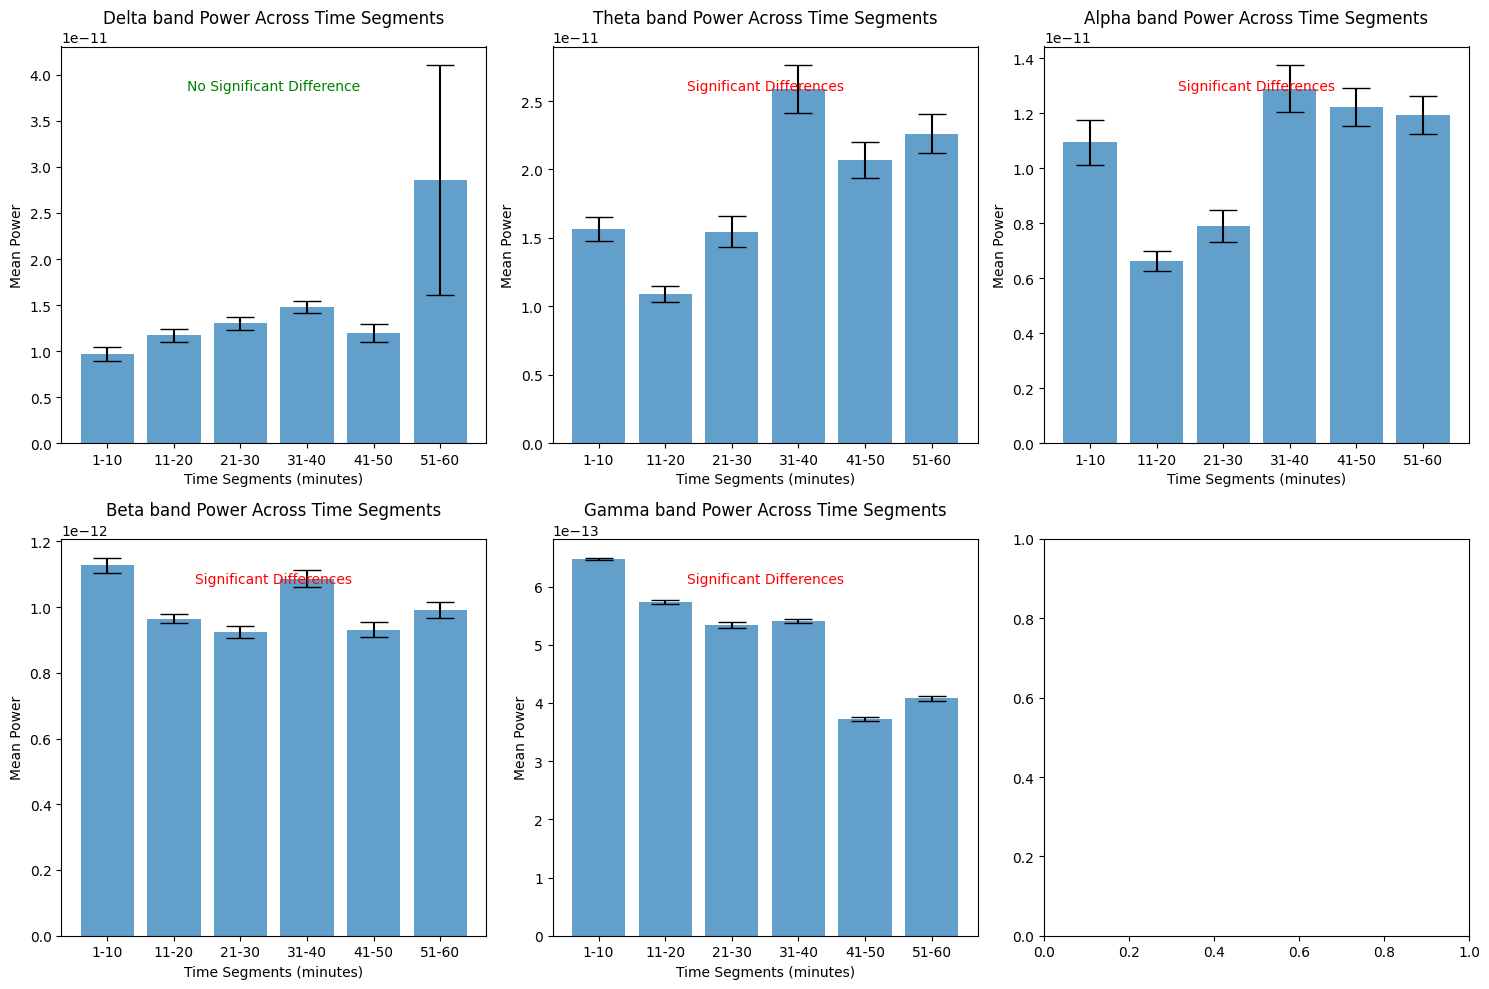

In [9]:
# Define the time segments in seconds
time_segments = [(1 * 60, 10 * 60), (11 * 60, 20 * 60), (21 * 60, 30 * 60),
                 (31 * 60, 40 * 60), (41 * 60, 50 * 60), (51*60, 60*60)]

# Calculate PSD for each time segment and store band powers
segmented_band_powers = {'Delta': [], 'Theta': [], 'Alpha': [], 'Beta': [], 'Gamma': []}
frequency_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 14), 'Beta': (14, 30), 'Gamma': (30, 40)}

for start, end in time_segments:
    segment_data, times = raw_60mins_cut.copy().crop(tmin=start, tmax=end).get_data(return_times=True)
    sfreq = raw_60mins_cut.info['sfreq']
    psd, freqs = mne.time_frequency.psd_array_welch(segment_data, sfreq=sfreq, fmin=0.5, fmax=40)

    for band, (fmin, fmax) in frequency_bands.items():
        # Find the indices corresponding to each band
        band_freq_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        # Average the power in the frequency band
        band_power = psd[:, band_freq_indices].mean(axis=1)
        segmented_band_powers[band].append(band_power)

# Perform ANOVA across the segments for each band
anova_results = {}
for band in frequency_bands:
    # Compute one-way ANOVA
    F_stat, p_val = f_oneway(*segmented_band_powers[band])
    anova_results[band] = (F_stat, p_val)

    # Determine significance based on p-value
    significance = "significant" if p_val < 0.05 else "not significant"

    # Print the result with significance
    print(f"{band} band ANOVA results: F = {F_stat:.3f}, p = {p_val:.3f} ({significance})")


# Plot the mean power for each segment and each band
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration
for ax, (band, powers) in zip(axs, segmented_band_powers.items()):
    # Calculate the mean and SEM for plotting
    means = [np.mean(segment) for segment in powers]
    sems = [np.std(segment) / np.sqrt(len(segment)) for segment in powers]
    x = np.arange(len(time_segments))

    # Bar plot with error bars
    ax.bar(x, means, yerr=sems, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{start//60}-{end//60}" for (start, end) in time_segments])
    ax.set_title(f'{band} band Power Across Time Segments')
    ax.set_ylabel('Mean Power')
    ax.set_xlabel('Time Segments (minutes)')

    # Significance
    if anova_results[band][1] < 0.05:
        ax.text(0.5, 0.9, 'Significant Differences', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
    else:
        ax.text(0.5, 0.9, 'No Significant Difference', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='green')

# Adjust the layout
plt.tight_layout()
plt.show()
